In [1]:
# ライブラリのインポート
%matplotlib inline
import keras
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler

qtdb/sel102 ECG dataset [2] という心電図データ

http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt


In [2]:
df = pd.read_csv('data/qtdbsel102.txt', header=None, delimiter='\t')
print(df.shape)

(45000, 3)


3列目のデータに注目して異常検知

In [3]:
ecg = df.iloc[:,2].values
ecg = ecg.reshape(len(ecg), -1)
print("length of ECG data:", len(ecg))

length of ECG data: 45000


データの前処理として、平均を0、分散を1

In [4]:
scaler = StandardScaler()
std_ecg = scaler.fit_transform(ecg)

傾向の確認

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

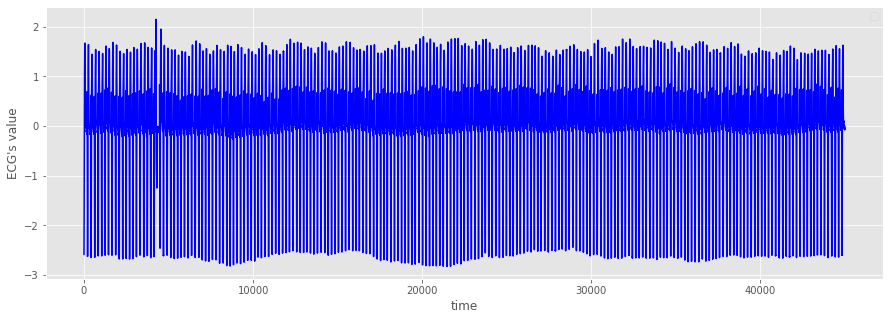

In [5]:
plt.figure()

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(45000), std_ecg[:45000], color='b')
plt.legend()

plt.show()

異常箇所の確認

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

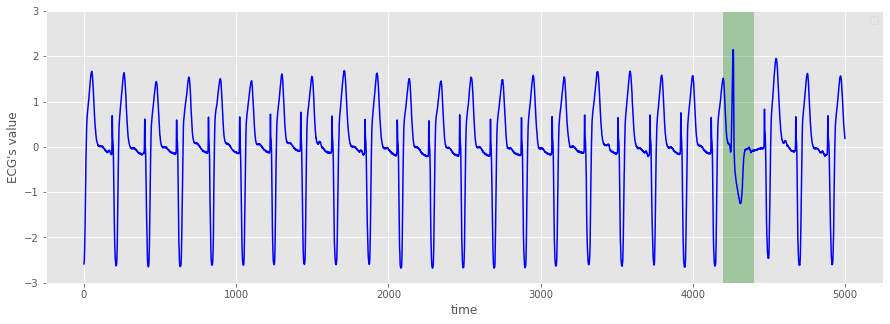

In [6]:
plt.figure()

plt.style.use('ggplot')
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('ECG\'s value')
plt.plot(np.arange(5000), std_ecg[:5000], color='b')
plt.ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
plt.fill_between(x, y1, y2, facecolor='g', alpha=.3)
plt.legend()

plt.show()

正常データのみで学習するために、5000ステップ以降のデータを取り出す。



In [7]:
normal_cycle = std_ecg[5000:]

所持しているデータを、学習データ、検証データ、テストデータに分割するため、以下のジェネレータを用意する。

なお、ここでは10個のデータから次の3個のデータを予測する。

注) delayとstepは今回は用いない。それぞれ、「delay後のデータを予測する」、「stepおきにデータを使用する」という意味。

In [8]:
def generator(data, lookback, delay, pred_length, min_index, max_index, shuffle=False,
              batch_size=100, step=1):
    if max_index is None:
        max_index = len(data) - delay - pred_length - 1 
    i = min_index + lookback 

    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, 
                                    size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                               lookback//step,
                               data.shape[-1]))

        targets = np.zeros((len(rows), pred_length))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay : rows[j] + delay + pred_length].flatten()

        yield samples, targets

In [9]:
lookback = 10
pred_length = 3
step = 1
delay = 1
batch_size = 100

# 訓練ジェネレータ
train_gen = generator(normal_cycle, 
                     lookback=lookback,
                     pred_length=pred_length,
                     delay=delay,
                     min_index=0,
                     max_index=20000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(normal_cycle, 
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=20001,
                   max_index=30000,
                   step=step,
                   batch_size=batch_size)


# 検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (30001 - 20001 -lookback) // batch_size

# その他は、テストデータ

ここでは、LSTMを二つ重ねたモデルを使用する。

LSTMは、時系列データに適したニューラルネットである。

最終5ステップのみ結果を載せる。




In [10]:
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(35, return_sequences = True, input_shape=(None,normal_cycle.shape[-1])))
model.add(layers.LSTM(35))
model.add(layers.Dense(pred_length))

model.compile(optimizer=RMSprop(), loss="mse")
history = model.fit_generator(train_gen,
                              steps_per_epoch=200,
                              epochs=60,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
200/200 [==============================] - 17s 54ms/step - loss: 0.3478 - val_loss: 0.0366
Epoch 2/60
200/200 [==============================] - 9s 44ms/step - loss: 0.0373 - val_loss: 0.0231
Epoch 3/60
200/200 [==============================] - 10s 48ms/step - loss: 0.0236 - val_loss: 0.0181
Epoch 4/60
200/200 [==============================] - 9s 43ms/step - loss: 0.0184 - val_loss: 0.0167
Epoch 5/60
200/200 [==============================] - 9s 47ms/step - loss: 0.0144 - val_loss: 0.0121
Epoch 6/60
200/200 [==============================] - 9s 46ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 7/60
200/200 [==============================] - 9s 44ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 8/60
200/200 [==============================] - 11s 56ms/step - loss: 0.0098 - val_loss: 0.0100
Epoch 9/60
200/200 [==============================] - 9s 46ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 10/60
200/200 [==============================] - 10s 48ms/step - loss: 0.0087 - va

学習データと検証データにおける損失値の推移を以下に示す。

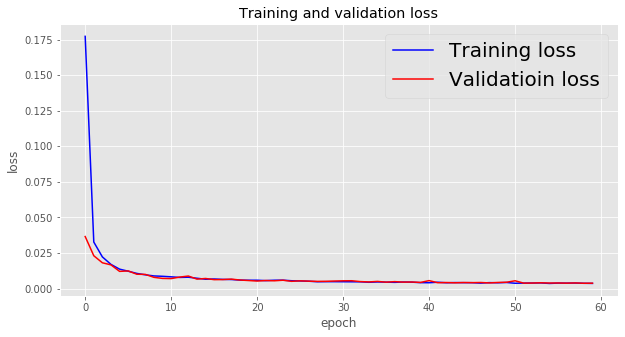

In [11]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.figure(figsize=(10,5))

plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validatioin loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and validation loss")
plt.legend(fontsize=20)

plt.show()

テストデータにおける予測値と目標値を用意する。

In [12]:
test_gen_pred = generator(normal_cycle, 
                    lookback=lookback,
                    pred_length=pred_length,
                    delay=delay,
                    min_index=30001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

test_steps = (len(normal_cycle) - 30001 - lookback) // batch_size

test_pred = model.predict_generator(test_gen_pred, steps=test_steps)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [13]:
test_gen_target = generator(normal_cycle, 
                    lookback=lookback,
                    pred_length=pred_length,
                    delay=delay,
                    min_index=30001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

test_target = np.zeros((test_steps * batch_size , pred_length))

for i in range(test_steps):
    test_target[i*batch_size:(i+1)*batch_size] = next(test_gen_target)[1]

mseを評価する。モデルが適切であることが確認できる。



In [14]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(test_pred, test_target))

0.0032041496107008565


グラフでも確認

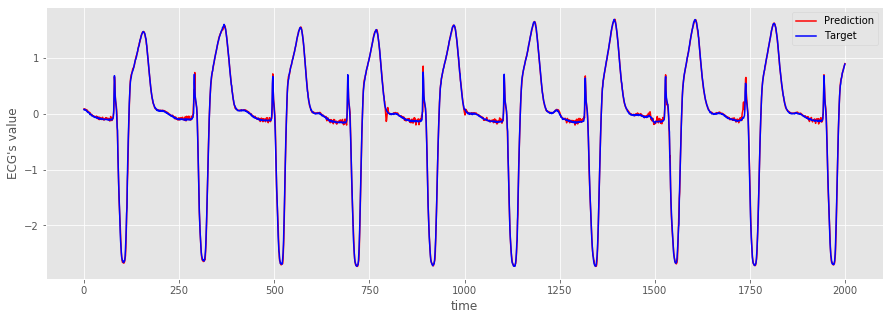

In [15]:
plt.figure(figsize=(15,5))


plt.plot(range(len(test_pred[0:2000,0])), test_pred[0:2000,0], "r", label="Prediction")
plt.plot(range(len(test_target[0:2000,0])), test_target[0:2000,0], "b", label="Target")
plt.xlabel("time")
plt.ylabel('ECG\'s value')
plt.legend(fontsize=10)

plt.show()

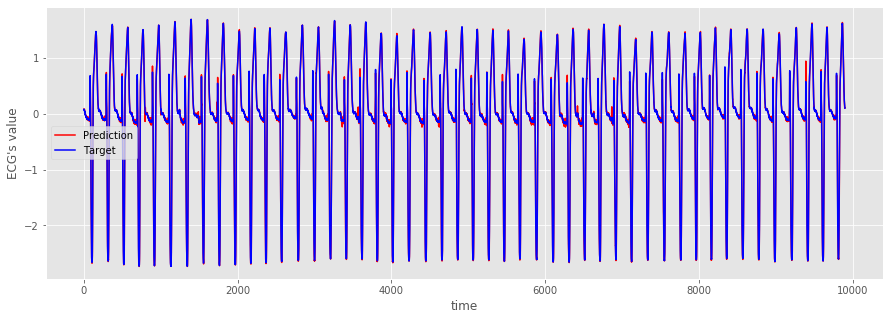

In [16]:
plt.figure(figsize=(15,5))

plt.plot(range(len(test_pred[:,0])), test_pred[:,0], "r", label="Prediction")
plt.plot(range(len(test_target[:,0])), test_target[:,0], "b", label="Target")
plt.xlabel("time")
plt.ylabel('ECG\'s value')
plt.legend(fontsize=10)

plt.show()

正規分布のフィッティング

In [17]:
error =  test_pred - test_target
mean = np.mean(error, axis=0)
print(mean)
cov = np.cov(error, rowvar=False, bias=True)
print(cov)

[ 0.00156793 -0.0010873  -0.00439107]
[[0.00134471 0.00148073 0.00131399]
 [0.00148073 0.00298469 0.00322789]
 [0.00131399 0.00322789 0.00526013]]


マハラノビス距離

In [18]:
def Mahalanobis_dist(x, mean, cov):
    d = np.dot(x-mean, np.linalg.inv(cov))
    d = np.dot(d, (x-mean).T)
    return d

異常値の検出

In [19]:
detection_gen_pred = generator(std_ecg, 
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=0,
                   max_index=5000,
                   step=step,
                   batch_size=batch_size)

detection_steps = (5000 -lookback) // batch_size

detection_pred = model.predict_generator(detection_gen_pred, steps=detection_steps)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [20]:
detection_gen_target = generator(std_ecg, 
                   lookback=lookback,
                   pred_length=pred_length,
                   delay=delay,
                   min_index=0,
                   max_index=5000,
                   step=step,
                   batch_size=batch_size)

detection_target = np.zeros((detection_steps * batch_size , pred_length))

for i in range(detection_steps):
    detection_target[i*batch_size:(i+1)*batch_size] = next(detection_gen_target)[1]


誤差ベクトルを用意して、マハラノビス距離を求める

In [21]:
error_detection = detection_pred - detection_target 

m_dist = []

for e in error_detection:
    m_dist.append(Mahalanobis_dist(e, mean, cov))

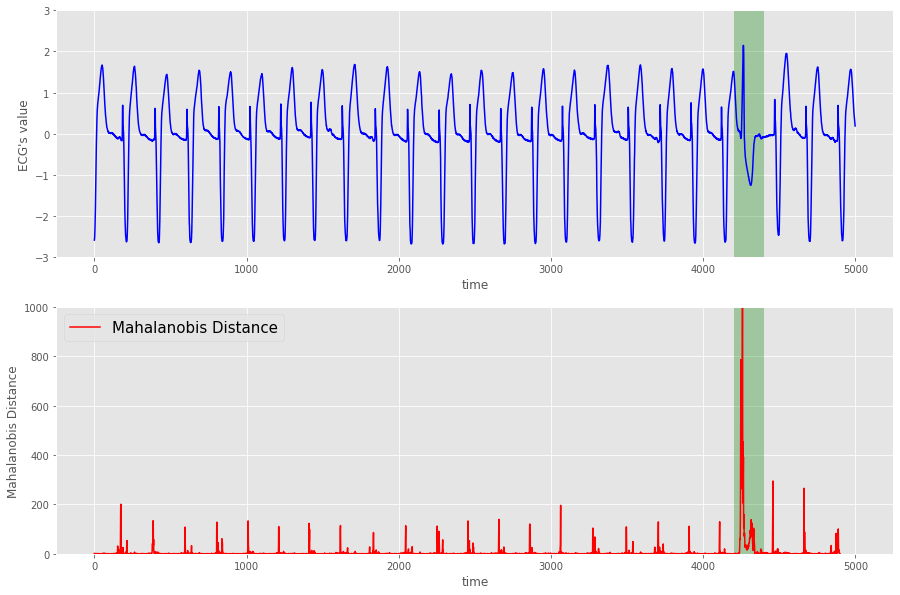

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(15,10))

axes[0].plot(std_ecg[:5000],color='b',label='original data')
axes[0].set_xlabel('time')
axes[0].set_ylabel('ECG\'s value' )
axes[0].set_xlim(-250, 5250)
axes[0].set_ylim(-3, 3)
x = np.arange(4200,4400)
y1 = [-3]*len(x)
y2 = [3]*len(x)
axes[0].fill_between(x, y1, y2, facecolor='g', alpha=.3)

axes[1].plot(m_dist, color='r',label='Mahalanobis Distance')
axes[1].set_xlabel('time')
axes[1].set_ylabel('Mahalanobis Distance')
axes[1].set_xlim(-250, 5250)
axes[1].set_ylim(0, 1000)
y1 = [0]*len(x)
y2 = [1000]*len(x)
axes[1].fill_between(x, y1, y2, facecolor='g', alpha=.3)

plt.legend(fontsize=15)
plt.show()


閾値の設定2
データに応じた最適な閾値を探そうというものである。
保有しているデータで正常or異常のラベル付けが可能ないしは既に為されている場合を想定する。

In [23]:
m_dist_th = np.zeros(4910)
m_dist_th[10:4910] = m_dist

In [24]:
TF_label = np.zeros(4910)
TF_label[4200:4400] = 1

閾値を設定することで、以下の値を得る。ただし、右辺は条件を満たすデータの個数を表すものとする。

\begin{align*}
    & TP = (\, Label:positive, \quad Prediction:positive \, )\\
    & FP = (\, Label:negative, \quad Prediction:positive \, )\\
    & FN = (\, Label:positive, \quad Prediction:negative \, )\\
    & TN = (\, Label:negative, \quad Prediction:negative \, )
\end{align*}

さらに、以下の指標を導入する。

\begin{align*}
    & precision = \frac{TP}{TP + FP} \\
    & recall = \frac{TP}{TP + FN} \\
    & F_{\beta} = (1+\beta^2) \frac{precision \cdot recal}{(\beta^2 \cdot precision) + recall}
\end{align*}

$F_{\beta}$ を最大化する閾値を探す。まずは、$F_{\beta}$を返す関数を定義する。


In [25]:
def f_score(th, TF_label, m_dist_th, beta):
    TF_pred = np.where(m_dist_th > th, 1, 0)
    TF_pred = 2 * TF_pred

    PN = TF_label + TF_pred

    TN = np.count_nonzero(PN == 0)
    FN = np.count_nonzero(PN == 1)
    FP = np.count_nonzero(PN == 2)
    TP = np.count_nonzero(PN == 3)

    precision = TP/(TP + FP)
    recall = TP/(TP+FN)

    return (1+beta**2)*precision*recall/(beta**2*precision + recall)

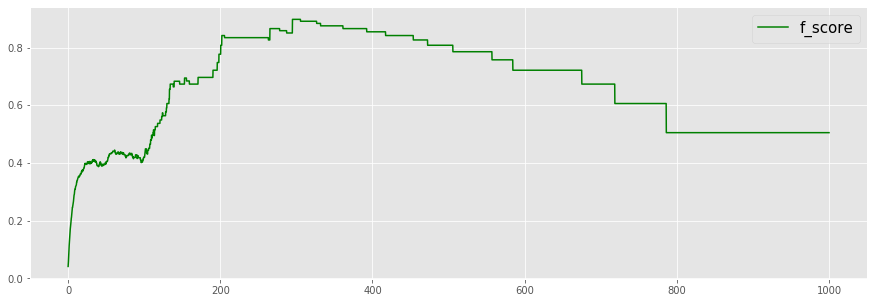

In [26]:
th_line = np.linspace(0, 1000, 5000)

dx = 0.2 

f_score_graph = []

for i in range(5000):
    f_score_graph.append(f_score(dx * i, TF_label, m_dist_th, 0.1))

plt.figure(figsize=(15,5))
plt.style.use('ggplot')
plt.plot(th_line, f_score_graph, color='g', label = "f_score")
plt.legend(fontsize=15)
plt.show()

In [27]:
from scipy import optimize

def minus_f_score(th, TF_label, m_dist_th, beta):
    return -f_score(th, TF_label, m_dist_th, beta)

ave_m_dist_th = np.average(m_dist_th)

opt_th = optimize.fmin_powell(minus_f_score, ave_m_dist_th, (TF_label, m_dist_th, 0.1))
print(opt_th)

Optimization terminated successfully.
         Current function value: -0.410847
         Iterations: 2
         Function evaluations: 86
34.42929496553913


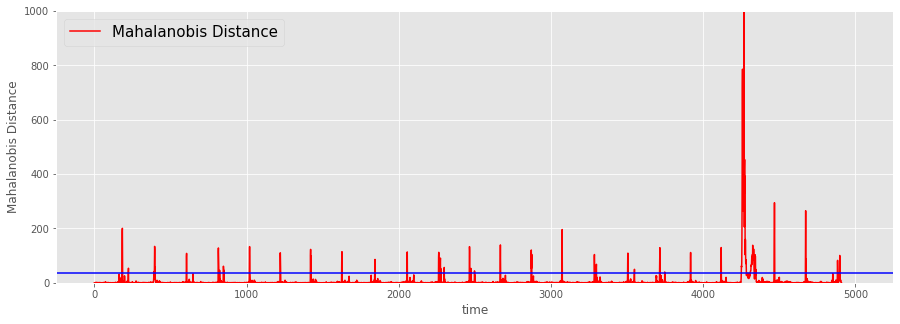

In [28]:
plt.figure(figsize=(15,5))

plt.style.use('ggplot')

plt.plot(m_dist_th, color='r',label='Mahalanobis Distance')
plt.xlabel('time')
plt.ylabel('Mahalanobis Distance')
plt.xlim(-250, 5250)
plt.ylim(0, 1000)

plt.plot(np.linspace(-250, 5250), [opt_th] * len(np.linspace(-250, 5250)), 'b')

plt.legend(fontsize=15)

plt.show()